In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [ ]:
torch.__version__

'2.1.1+cu121'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import (
    fix_all_seeds,
    train_loop,
    train_loop_with_projection_head,
    ModelWithProjectionHead,
    
)
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)

In [ ]:
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2023-12-15 18:29:13CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.35.2
openTSNE    : 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

distro         : 1.8.0
numpy          : 1.26.2
matplotlib     : 3.8.2
pandas         : 2.1.3
torch          : 2.1.1
scipy          : 1.11.4
jupyter_black  : 0.3.4
memory_profiler: 0.61.0

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

In [ ]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    engine="pyarrow",
)

CPU times: user 293 ms, sys: 76.9 ms, total: 370 ms
Wall time: 556 ms


In [ ]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [ ]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [ ]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

# Adding a projector during training
(Run 7)

Train using the representation after the projection head, but evaluate using the representation before the projection head (guillotine regularization).

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    "allenai/scibert_scivocab_uncased",
    "allenai/specter",
    "malteos/scincl",
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    "allenai/specter2_base",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # fix random seeds
    fix_all_seeds()

    # set up model
    print("Model (+ projection head): ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = ModelWithProjectionHead(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )
    print("Training loader length: ", len(training_loader))

    losses, knn_accuracies = train_loop_with_projection_head(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        n_epochs=2,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path / saving_path / "losses_train_with_projector_head_run7",
        losses,
    )
    np.save(
        variables_path
        / saving_path
        / "knn_accuracies_train_with_projector_head_run7",
        knn_accuracies,
    )

Model (+ projection head):  BERT
Running on device: cuda
bert-base-uncased
Training loader length:  368


  0%|          | 0/368 [00:00<?, ?it/s]

## Plot

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

/tmp/ipykernel_18968/3868890561.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[0, 1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
/tmp/ipykernel_18968/3868890561.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
/tmp/ipykernel_18968/3868890561.py:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as valu

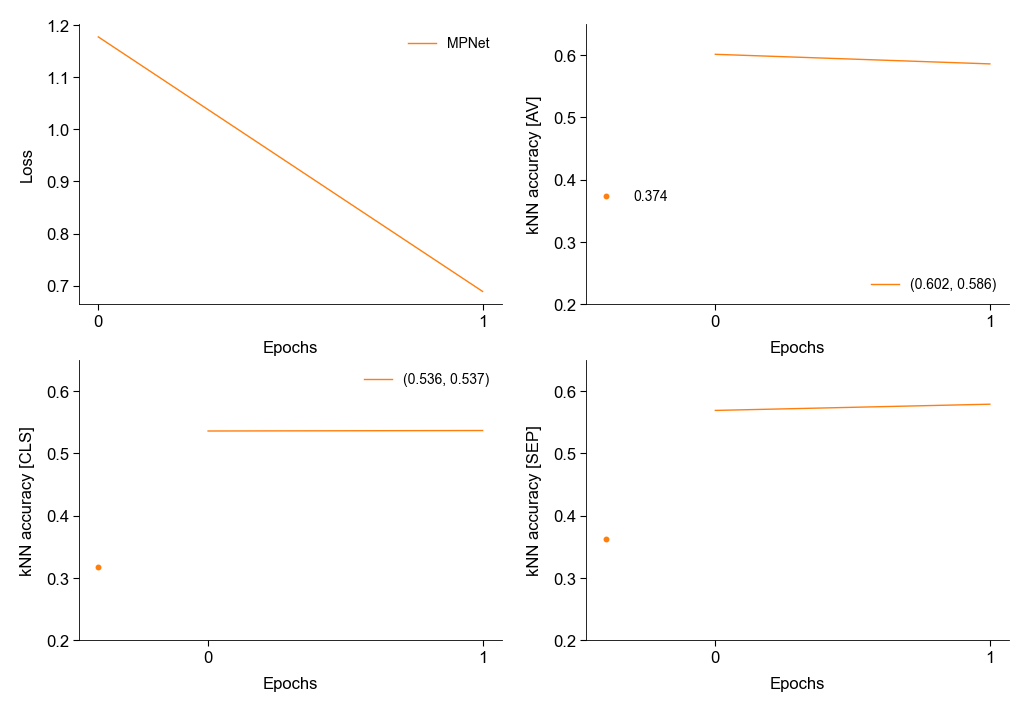

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 2
colormap = plt.get_cmap("tab10")
model_name = "MPNet"

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(
    variables_path / saving_path / "losses_train_with_projector_head_run7.npy"
)
knn_accuracies = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_train_with_projector_head_run7.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_acc_highd = np.load(variables_path / "updated_dataset" / saving_name_2)

color = colormap(1)

axs[0, 0].plot(
    np.arange(n_epochs),
    np.mean(losses, axis=1),
    label=model_name,
    color=color,
)
axs[0, 0].set_xticks(np.arange(n_epochs))
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].legend()

axs[0, 1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 0],
    label=f"({knn_accuracies[0, 0]:.3f}, {knn_accuracies[-1, 0]:.3f})",
    color=color,
)
axs[0, 1].scatter(-0.4, knn_acc_highd[0], c=color, s=5)
axs[0, 1].text(
    -0.3,
    knn_acc_highd[0],
    f"{knn_acc_highd[0]:.3f}",
    fontsize=5,
    va="center",
    ha="left",
)
axs[0, 1].set_xticks(np.arange(n_epochs))
axs[0, 1].set_ylim(0.2, 0.65)
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("kNN accuracy [AV]")
axs[0, 1].legend(loc="lower right")

axs[1, 0].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 1],
    label=f"({knn_accuracies[0, 1]:.3f}, {knn_accuracies[-1, 1]:.3f})",
    color=color,
)
axs[1, 0].scatter(-0.4, knn_acc_highd[1], c=color, s=5)
axs[1, 0].set_xticks(np.arange(n_epochs))
axs[1, 0].set_ylim(0.2, 0.65)
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("kNN accuracy [CLS]")
axs[1, 0].legend()

axs[1, 1].plot(
    np.arange(n_epochs),
    knn_accuracies[:, 2],
    label=model_name,
    color=color,
)
axs[1, 1].scatter(-0.4, knn_acc_highd[2], c=color, s=5)
axs[1, 1].set_xticks(np.arange(n_epochs))
axs[1, 1].set_ylim(0.2, 0.65)
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_training_run7_v1.png")

### Fancy plot

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [ ]:
colormap = plt.get_cmap("tab10")
dict_original_colors = dict()
for i, model_name in enumerate(model_names):
    color = colormap(i)
    dict_original_colors[model_name] = colormap(i)

In [ ]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

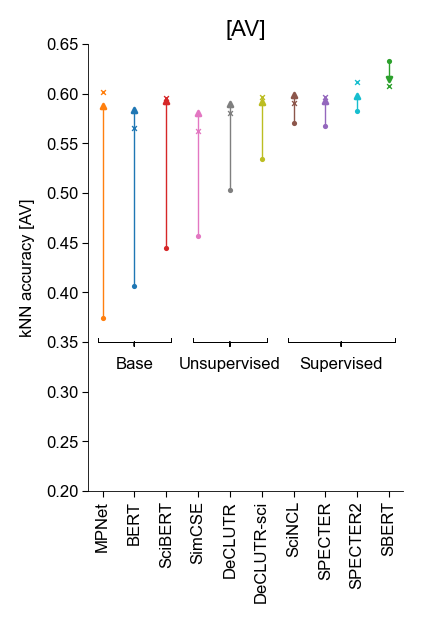

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2, 3), dpi=200)

rep = 0  # av

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    losses = np.load(variables_path / saving_path / "losses_run1.npy")
    knn_accuracies_after = np.load(
        variables_path / saving_path / "knn_accuracies_run1.npy"
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_accuracies_before = np.load(
        variables_path / "updated_dataset" / saving_name_2
    )

    knn_accuracies_run7 = np.load(
        variables_path
        / saving_path
        / "knn_accuracies_train_with_projector_head_run7.npy"
    )


    color = dict_original_colors[model_name]

    ax.plot(
        np.ones(2) * i,
        np.array([knn_accuracies_before[rep], knn_accuracies_after[0, rep]]),
        label=f"{model_name}",
        color=color,
    )
    ax.scatter(
        i,
        knn_accuracies_before[rep],
        color=color,
        marker=".",
        s=3,
    )
    if knn_accuracies_before[rep] <= knn_accuracies_after[0, rep]:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="^",
            s=3,
        )
    else:
        ax.scatter(
            i,
            knn_accuracies_after[0, rep],
            color=color,
            marker="v",
            s=3,
        )

    ax.scatter(
        i,
        knn_accuracies_run7[0, rep],
        color=color,
        marker="x",
        s=3,
    )


    ax.set_xticks(np.arange(len(model_names)))
    ax.set_xticklabels(model_names, rotation="vertical")
    ax.set_ylim(0.2, 0.65)
    ax.set_ylabel("kNN accuracy [AV]")
    ax.set_title("[AV]")
    ax.annotate(
        "Base",
        xy=(1, 0.35),
        xytext=(1, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Unsupervised",
        xy=(4, 0.35),
        xytext=(4, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=2.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )

    ax.annotate(
        "Supervised",
        xy=(7.5, 0.35),
        xytext=(7.5, 0.32),
        xycoords="data",
        fontsize=6,
        ha="center",
        va="bottom",
        bbox=dict(boxstyle="square", fc="white", edgecolor="None"),
        arrowprops=dict(
            arrowstyle="-[, widthB=3.2, lengthB=0.25", lw=0.35, color="k"
        ),
    )


fig.savefig(
    figures_path / "loss_and_knn_accuracy_training_run1_and_run7_v3.png"
)